In [1]:
import numpy as np
import os
import torch
import pandas as pd
from models import model
from read_data import read_data
import matplotlib.pyplot as plt
import seaborn as sns

## Carga de datos

In [2]:
# Leemos los archivos raw
folder = os.path.join('..', 'Date')
dataframes1 = read_data.read_raw(folder)
folder = os.path.join('..', 'Date2')
dataframes2 = read_data.read_raw(folder)

In [3]:
# Convertimos todo en arrays de numpy con series del mismo largo
data_1 = read_data.read_and_perform(dataframes1, row_range=300, col_range=(3,12), split= True)
data_2 = read_data.read_and_perform(dataframes2, row_range=99, col_range=(2,5), split= False)
# concatenamos todas las series
data_total = np.vstack([data_1.T, data_2.T])

# separamos train y test
train, test = read_data.train_test_split(data_total)

[+] Se procesaron 297 series de longitud 99
[+] Se procesaron 32 series de longitud 99


In [4]:
# escalamos
scaler = read_data.scalings(train)
train = scaler.fit_transform(train)
print(f'[+] Train shape {train.shape}')
test = scaler.transform(test)
print(f'[+] Test shape {test.shape}')

[+] StandardScaler entrenado
[+] Train shape (310, 99)
[+] Test shape (19, 99)


## Entrenar modelo para un solo espacio latente

In [8]:
# Crear el directorio para guardar las imágenes si no existe
path_img = os.path.join("..","img","Drop-Optimo")
os.makedirs(path_img, exist_ok=True)

In [ ]:
epochs = 1000
lr = 1e-3
lat = 9
drop = np.linspace(0.1,0.6,6)

for dr in drop:
    # Entrenamiento
    hist_train = []
    hist_test = []
    autoencoder = model.NNAutoencoder(99, lat, dr)
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr = lr)
    criterio = torch.nn.MSELoss()

    for e in range(epochs):
        autoencoder.train()
        x = torch.FloatTensor(train)
        y_pred = autoencoder(x)
        loss = criterio(y_pred, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if e%100 == 0:
            print(e, "loss =",loss.item())
        hist_train.append(loss.item())
        
        with torch.no_grad():
            autoencoder.eval()
            x = torch.FloatTensor(test)
            y_pred = autoencoder(x)
            loss = criterio(y_pred, x)
            hist_test.append(loss.item())

    #guardo las img
    plt.semilogy(hist_train, label = 'train loss')
    plt.semilogy(hist_test, label = 'test loss')
    plt.title(f"Loss train -eval, drop = {dr}")
    plt.legend()
    plt.savefig(os.path.join(path_img,f"img{lat}-drop{dr}.png"), bbox_inches='tight')
    plt.close()


## Early stopping

Es  una técnica que permite detener el entrenamiento cuando el valor de pérdida en el conjunto de validación (test) comienza a aumentar. Esto ayuda a prevenir el sobreajuste y permite guardar el mejor modelo basado en el mínimo valor de pérdida en el conjunto de validación

In [9]:
# Crear el directorio para guardar las imágenes si no existe
path_model = os.path.join("..","Save-Models")
os.makedirs(path_model, exist_ok=True)

Epoch 0, train Loss: 1.0040, test Loss: 0.7560
Epoch 100, train Loss: 0.1353, test Loss: 0.1483
Epoch 200, train Loss: 0.1157, test Loss: 0.1298
Epoch 300, train Loss: 0.0665, test Loss: 0.0568
Epoch 400, train Loss: 0.0554, test Loss: 0.0537
Epoch 500, train Loss: 0.0501, test Loss: 0.0531
Epoch 600, train Loss: 0.0423, test Loss: 0.0456
Epoch 700, train Loss: 0.0445, test Loss: 0.0469
Epoch 800, train Loss: 0.0407, test Loss: 0.0479
Epoch 900, train Loss: 0.0400, test Loss: 0.0462
Best epoch was 326 with val loss 0.0459


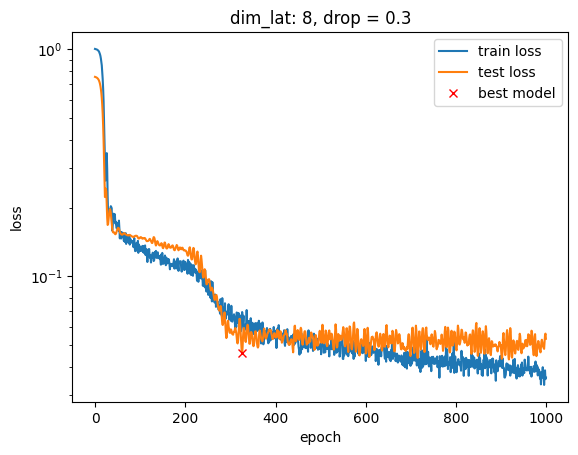

In [13]:
epochs = 1000
lr = 1e-3
dr = 0.3
lat = 8

# Entrenamiento
hist_train = []
hist_test = []
best_test_loss = 100
best_epoch = 0
best_model = None
espera = 100
b = 0 #bandera

autoencoder = model.NNAutoencoder(99, lat, dr)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr = lr)
criterio = torch.nn.MSELoss()

for e in range(epochs):
    autoencoder.train()
    x = torch.FloatTensor(train)
    y_pred = autoencoder(x)
    loss = criterio(y_pred, x)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    hist_train.append(loss.item())
    
    with torch.no_grad():
        autoencoder.eval()
        x = torch.FloatTensor(test)
        y_pred = autoencoder(x)
        test_loss = criterio(y_pred, x)
        hist_test.append(test_loss.item())

    if e%100 == 0:
            print(f'Epoch {e}, train Loss: {loss.item():.4f}, test Loss: {test_loss.item():.4f}')

    if test_loss < loss:
        #guardo el mejor modelo
        if test_loss < best_test_loss: #encuantra el primer minimo??
            best_test_loss = test_loss
            best_epoch = e
            best_model = autoencoder.state_dict().copy() #copia del mejor modelo

        if (e - best_epoch >= espera) and (b == 0):
            m_epoch = best_epoch
            m_test_loss = best_test_loss
            torch.save(best_model, os.path.join(path_model,f"model-lat{lat}.pth"))
            b = 1

print(f'Best epoch was {m_epoch} with val loss {m_test_loss:.4f}')
#guardo las img
plt.semilogy(hist_train, label = 'train loss')
plt.semilogy(hist_test, label = 'test loss')
plt.plot(m_epoch,m_test_loss,'x', color = "red", label = "best model")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title(f"dim_lat: {lat}, drop = {dr}")
plt.legend()
#plt.savefig(os.path.join(path_img,f"img4-drop{dr}.png"), bbox_inches='tight')
#plt.close()

In [ ]:
MAES_list = []
for i in range(500):
    autoencoder.train()
    x = torch.FloatTensor(test)
    y_pred = autoencoder(x)
    sample = scaler.inverse_transform(x)
    sample_pred = scaler.inverse_transform(y_pred.detach().numpy())

    average_MAES = np.abs(sample-sample_pred).mean()
    MAES_list.append(average_MAES)
    print(f'DIM= {i} & Average MAE= {average_MAES:.3f}')

array = np.array(MAES_list)
mean = np.mean(array)
std = np.std(array) 

In [ ]:
#curva
# Crear el histograma
#plt.figure(figsize=(10, 6))
sns.histplot(MAES_list, kde = True, bins=50, edgecolor='black')

# Añadir etiquetas y título
plt.xlabel('MAES')
plt.ylabel('f')
plt.title('Frecuencia de ocurrencia')

### Calculo MAE vs Dim Latent

In [ ]:
latent = np.array(range(1,21)) #Espacio latente del 1 al 20
MAES_list = [] #se guardaran ls MAES de cada espacio latente
epochs = 1000
lr = 1e-3
drop = 0.0005

for lat in latent:
    # Modelo
    autoencoder = model.NNAutoencoder(99, lat, drop)
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr = lr)
    criterio = torch.nn.MSELoss()
    # Entrenamiento
    hist_train = []
    hist_test = []
    for e in range(epochs):
        autoencoder.train()
        x = torch.FloatTensor(train)
        y_pred = autoencoder(x)
        loss = criterio(y_pred, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluacion
    with torch.no_grad():
        autoencoder.eval()
        x = torch.FloatTensor(test)
        y_pred = autoencoder(x)
        sample = scaler.inverse_transform(x)
        sample_pred = scaler.inverse_transform(y_pred.numpy())

    average_MAES = np.abs(sample-sample_pred).mean()
    MAES_list.append(average_MAES)
    print(f'DIM= {lat} & Average MAE= {average_MAES:.3f}')

In [ ]:
fig, ax = plt.subplots(figsize = (10,6))
ax.errorbar(latent,MAES_list,0.05,fmt='o', linewidth=2, capsize=6)
ax.plot(latent,MAES_list)
ax.set_ylabel("MAES")
ax.set_xlabel("Laten Dim")
ax.set_xticks(np.arange(0, 22, 1))
ax.grid()

In [ ]:
y = np.array(MAES_list)

In [ ]:
# Crear el histograma
plt.figure(figsize=(10, 6))
plt.hist(y, bins=50, edgecolor='black')

# Añadir etiquetas y título
plt.xlabel('MAES')
plt.ylabel('f')
plt.title('Frecuencia de ocurrencia')